In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
from underpinnings.OccupancyMap2 import LidarMeasurement, ExactLidarMeasurement,index_logodds_map_cells,apply_lidar_to_occupancy_map, OccupancyMap2,LocalizationException
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp

In [2]:
sensor_log,first_timestamp=load_sensor_log_file("../to_study/map_tests/turn_test_sensor_log.txt")
gridmap=OccupancyMap2.load_from_file("../to_study/map_tests/turn_test_map.npy")
#gridmap=OccupancyMap2.load_from_file("../to_study/wide_map.npy")


In [3]:
print(sensor_log[12])

{'pose_measurement': {'vals': [0, 0, -0.2964938437788833], 'covariance': [[1000000000000.0, 0, 0], [0, 1000000000000.0, 0], [0, 0, 0.04000000000000001]]}, 'timestamp': 1620432287.1804218, 'notes': 'compass'}


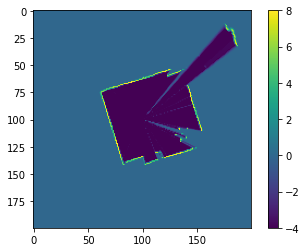

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(gridmap.gridmap_logodds[100:300,100:300])
plt.colorbar()
plt.show()

In [5]:
lidar_time=[]
lidar_pose=[]
compass_time=[]
compass_val=[]
pose_time=[]
pose_val=[]
last_pose=BayesianArray(np.array([0,0,0]),100.0*np.eye(3))
counter=0
every=1
start_at=25
print("resolution is {}".format(np.radians(1)))
for i in range(len(sensor_log)):
    if sensor_log[i]['timestamp']-first_timestamp<start_at:
        continue
    if 'latest_pose' in sensor_log[i]:
        last_pose=BayesianArray.from_object(sensor_log[i]['latest_pose'])
        pose_time.append(sensor_log[i]['timestamp']-first_timestamp)
        pose_val.append(last_pose.vals)
    if 'pose_measurement' in sensor_log[i] and sensor_log[i]['notes']=='compass':
        compass_time.append(sensor_log[i]['timestamp']-first_timestamp)
        compass_val.append(sensor_log[i]['pose_measurement']['vals'][2])        
    if 'lidar/lidar_scan' in sensor_log[i]:
        counter+=1
        if counter%every!=0:
            continue        
        scan_data=sensor_log[i]['lidar/lidar_scan']
        #last_pose=BayesianArray(np.array([0,0,0]),100.0*np.eye(3))
        m=ExactLidarMeasurement([ x[2]/1000 for x in scan_data ],[ np.radians(x[1]) for x in scan_data ])
        m=m.downsample(2)
        l_theta_points=5
        #l_theta_res=np.radians(1)
        l_theta_res=np.radians(2)
        try:
            posemap,xs,ys,ts,counts=gridmap.get_lidar_pose_map5_withtheta(last_pose.vals,m,theta_points=l_theta_points,theta_res=l_theta_res)
            spread_size_x=25
            spread_size_y=25
            pred_pose,score=gridmap.pose_map_to_pose_prediction4_with_theta_faster(posemap,xs,ys,ts,counts,center=last_pose,spread_size_x=spread_size_x,spread_size_y=spread_size_y,supress_errors=False)
        except LocalizationException as e:
            print("exception {}".format(e.message))
            l_theta_points=20
            l_theta_res=np.radians(3)
            posemap,xs,ys,ts,counts=gridmap.get_lidar_pose_map5_withtheta(last_pose.vals,m,theta_points=l_theta_points,theta_res=l_theta_res)
            spread_size_x=25
            spread_size_y=25
            pred_pose,score=gridmap.pose_map_to_pose_prediction4_with_theta_faster(posemap,xs,ys,ts,counts,center=last_pose,spread_size_x=spread_size_x,spread_size_y=spread_size_y,supress_errors=False)
        lidar_time.append(sensor_log[i]['timestamp']-first_timestamp)
        lidar_pose.append(pred_pose.vals)
        print("{} {}".format(sensor_log[i]['timestamp']-first_timestamp,pred_pose.pretty_str()))
        
    

resolution is 0.017453292519943295
exception Best point on edge of map: (0, 22, 24) out of (11, 51, 51)
25.097357034683228  0.025+/-0.025 0.025+/-0.025 -0.314+/-0.026
25.187095403671265  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
25.309767961502075  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
25.49156355857849  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
25.693052768707275  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
25.89448881149292  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
25.995253801345825  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.107916116714478  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.31237006187439  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.414098024368286  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.506850242614746  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.707602739334106  0.025+/-0.025 0.025+/-0.025 -0.292+/-0.017
26.811280727386475  0.025+/-0.025 0.025+/-0.025 -0.291+/-0.017
26.90500020980835  0.025+/-0.025 0.025+/-0.025 -0.291+/-0.017
27.1184298992157  

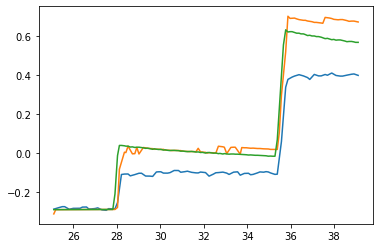

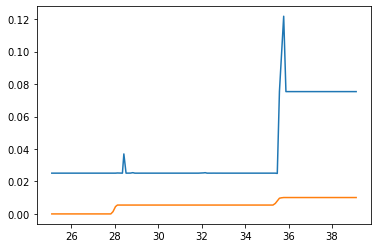

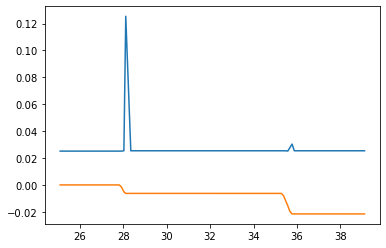

In [6]:
pose_vals=np.array(pose_val)

lidar_pose=np.array(lidar_pose)
plt.figure()
#plt.ylim(0.64,0.71)
plt.plot(compass_time,compass_val)
plt.plot(lidar_time,lidar_pose[:,2])
plt.plot(pose_time,pose_vals[:,2])
plt.show()

plt.figure()
plt.plot(lidar_time,lidar_pose[:,0])
plt.plot(pose_time,pose_vals[:,0])
plt.show()
plt.figure()
plt.plot(lidar_time,lidar_pose[:,1])
plt.plot(pose_time,pose_vals[:,1])
plt.show()
#conclusion:  the compass is probably wrong; I don't see how the lidar could have that much error


In [7]:
sensor_log,first_timestamp=load_sensor_log_file("../to_study/map_tests/forward_test_sensor_log.txt")
gridmap=OccupancyMap2.load_from_file("../to_study/map_tests/forward_test_map.npy")

In [10]:
import time
lidar_time=[]
lidar_pose=[]
compass_time=[]
compass_val=[]
pose_time=[]
pose_val=[]
last_pose=BayesianArray(np.array([0,0,0]),100.0*np.eye(3))
counter=0
every=1
print("resolution is {}".format(np.radians(1)))
wait_until=28
for i in range(len(sensor_log)):
    if sensor_log[i]['timestamp']-first_timestamp<wait_until:
            continue
    if 'latest_pose' in sensor_log[i]:
        last_pose=BayesianArray.from_object(sensor_log[i]['latest_pose'])
        pose_time.append(sensor_log[i]['timestamp']-first_timestamp)
        pose_val.append(last_pose.vals)
    if 'pose_measurement' in sensor_log[i] and sensor_log[i]['notes']=='compass':
        compass_time.append(sensor_log[i]['timestamp']-first_timestamp)
        compass_val.append(sensor_log[i]['pose_measurement']['vals'][2])        
    if 'lidar/lidar_scan' in sensor_log[i]:
        
        counter+=1
        if counter%every!=0:
            continue        
        scan_data=sensor_log[i]['lidar/lidar_scan']
        #last_pose=BayesianArray(np.array([0,0,0]),100.0*np.eye(3))
        m=ExactLidarMeasurement([ x[2]/1000 for x in scan_data ],[ np.radians(x[1]) for x in scan_data ])
        m=m.downsample(2)
        l_theta_points=5
        l_theta_res=np.radians(2)
        start_time=time.time()
        try:
            posemap,xs,ys,ts,counts=gridmap.get_lidar_pose_map5_withtheta(last_pose.vals,m,theta_points=l_theta_points,theta_res=l_theta_res)
            spread_size_x=25
            spread_size_y=25
            pred_pose,score=gridmap.pose_map_to_pose_prediction4_with_theta_faster(posemap,xs,ys,ts,counts,center=last_pose,spread_size_x=spread_size_x,spread_size_y=spread_size_y,supress_errors=False)
        except LocalizationException as e:
            print("exception {}".format(e.message))
            l_theta_points=20
            l_theta_res=np.radians(3)
            posemap,xs,ys,ts,counts=gridmap.get_lidar_pose_map5_withtheta(last_pose.vals,m,theta_points=l_theta_points,theta_res=l_theta_res)
            spread_size_x=25
            spread_size_y=25
            pred_pose,score=gridmap.pose_map_to_pose_prediction4_with_theta_faster(posemap,xs,ys,ts,counts,center=last_pose,spread_size_x=spread_size_x,spread_size_y=spread_size_y,supress_errors=False)
        total_time=time.time()-start_time
        lidar_time.append(sensor_log[i]['timestamp']-first_timestamp)
        lidar_pose.append(pred_pose.vals)
        print("{} {} ({} s)".format(sensor_log[i]['timestamp']-first_timestamp,pred_pose.pretty_str(),total_time))
     

resolution is 0.017453292519943295
exception Best point on edge of map: (10, 29, 27) out of (11, 51, 51)
28.02578854560852  0.025+/-0.025 0.025+/-0.025 0.419+/-0.026 (0.8337216377258301 s)
28.130834579467773  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17253851890563965 s)
28.22455930709839  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17656493186950684 s)
28.42801570892334  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17852210998535156 s)
28.52276301383972  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17752552032470703 s)
28.63554835319519  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17350029945373535 s)
28.829710960388184  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17453336715698242 s)
28.938448429107666  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17453312873840332 s)
29.027220249176025  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.18055391311645508 s)
29.232634782791138  0.025+/-0.025 0.025+/-0.025 0.394+/-0.026 (0.17549443244934082 s)
29.32438850402832  0.025+/-0.025 0.025+/-

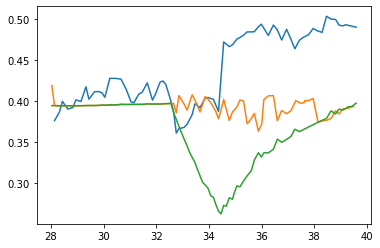

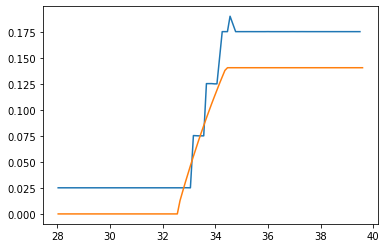

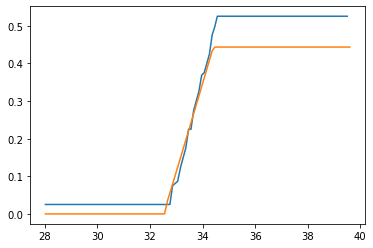

In [9]:
lidar_pose=np.array(lidar_pose)
pose_vals=np.array(pose_val)

lidar_pose=np.array(lidar_pose)
plt.figure()
#plt.ylim(0.64,0.71)
plt.plot(compass_time,compass_val)
plt.plot(lidar_time,lidar_pose[:,2])
plt.plot(pose_time,pose_vals[:,2])

plt.show()
plt.figure()
plt.plot(lidar_time,lidar_pose[:,0])
plt.plot(pose_time,pose_vals[:,0])
plt.show()
plt.figure()
plt.plot(lidar_time,lidar_pose[:,1])
plt.plot(pose_time,pose_vals[:,1])
plt.show()